# Modeling!

In [2]:
import os

## Stage 1: Pipeline

#### Loading Fcn

In [3]:
import pandas as pd 

In [4]:
def load_and_join(headlines, bodies): 
    train_bodies = pd.read_csv(bodies).set_index('Body ID')
    train_headlines = pd.read_csv(headlines).set_index('Body ID')
    #remove non-english article bodies
    train_bodies['language'] = train_bodies.articleBody.swifter.apply(detect_lang)
    bad_lang = train_bodies.loc[train_bodies.language!='en'].index
    train_bodies.drop(['language'],inplace=True,axis=1)
    train_bodies.drop(bad_lang,inplace=True)   
    return train_headlines, train_bodies

def detect_lang(txt):
    return detect(txt)

### Stage 1: Preprocess

#### Functions:

In [5]:
#Libs
import spacy
import en_core_web_lg
import swifter
import nltk
import re
import warnings
from langdetect import detect

In [6]:
# global
nlp = en_core_web_lg.load()

In [7]:
# accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
#            'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY', 'NOUN','PROPN','NUM']
# len(accepted)

In [8]:
#accepted = ['NOUN']
#accepted = ['NOUN','PROPN']
#accepted = ['NOUN','PROPN', 'NUM']
accepted = ['NOUN','PROPN', 'NUM','ORG','DATE']
# accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
#            'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY', 'NOUN','PROPN','NUM']
# accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
#            'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY']

In [290]:
#functions
from textblob import TextBlob, WordList

def clean_txt(txt):
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt) 
    return ' '.join( [w for w in txt.split() if len(w)>1] )

def noun_tag(text): 
    doc = nlp(text) 
    doc = [x for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' ]]
    doc = [get_stem(X.text) for X in doc if X.ent_type_ in accepted or X.pos_ in accepted]
    return doc

def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

#### Code:

First step here is to load in the two training datasets and join

In [214]:
warnings.filterwarnings('ignore')

In [269]:
global_pth = '/Users/nicholascalen/fnc-1/'
pth_to_bodies = global_pth + 'train_bodies.csv'
pth_to_headlines = global_pth + 'train_stances.csv'
headlines, bodies = load_and_join(pth_to_headlines, pth_to_bodies)

Pandas Apply:   0%|          | 0/1683 [00:00<?, ?it/s]

In [270]:
len(headlines), len(bodies)

(49972, 1680)

In [ ]:
#bodies = bodies.sample(500)
headlines = headlines.sample(2000)

Next we want to prep the data for modeling. We know from inspection during the EDA that only the nouns really contribute to the label for the first stage target ('related'/'unrelated') so we want to extract those. We also want to keep numbers. There's a few special characters that pop up, specifcally, $ and # so we want to remove those. So first we'll clean those characters away, tag the nouns and numbers, lemmetize them then return the results for each row. 

In [271]:
bodies['body_ents'] = bodies['articleBody'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
headlines['headline_ents'] = headlines['Headline'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
df = headlines.join(bodies).dropna()
df.shape

Pandas Apply:   0%|          | 0/1680 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1680 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49972 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49972 [00:00<?, ?it/s]

(49909, 5)

In [272]:
df['target_stage1'] = 'None'
df['labels'] = df.Stance
df.loc[df.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
df.loc[df.Stance != 'unrelated', 'target_stage1'] = 'related'
df.loc[df.Stance == 'unrelated', 'labels'] = None

### Stage 1: Model

#### Functions

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib as ml
%matplotlib inline
ml.style.use('fivethirtyeight')
sns.set_style('ticks')


In [274]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    if len(union) == 0: 
        return len(intersection)/(len(union) + 1)
    else: 
        return len(intersection)/(len(union))

def objective_a(threshold): 
    df['pred'] ='unrelated'
    df.loc[df.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(df.target_stage1, df.pred)

def objective_b(token):
    df['pred'] ='unrelated'
    df['jaccard_similarity_nouns'] = df.apply(lambda x: jaccard_similarity_token_opt(x.headline_ents, 
                                                                                     x.body_ents, 
                                                                                     token), axis=1)
    df.loc[df.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(df.target_stage1, df.pred)

def jaccard_similarity_token_opt(query, document,token):
    token = int(np.ceil(token))
    intersection = set(query).intersection(set(document[:token]))
    union = set(query).union(set(document[:token]))
    if len(union) == 0: 
        return len(intersection)/(len(union) + 1)
    else: 
        return len(intersection)/(len(union))

#### Code:

Now that we have tagged the nouns we can use the jaccard similarity score to produce our model. Jaccard score should produce two distinct groups where the lower score indicates unrelated headline/body pairs and a higher score indicates more relatedness. 

In [278]:
# df['headline_ents'] = df['headline_ents'].apply(lambda x: [y for y in x if y not in ['report','man', 'woman',
#                                                                                          'appl','state','plan',
#                                                                                          'famili', 'video',
#                                                                                          'al','compani']])

In [279]:
df['jaccard_similarity_nouns'] = df.apply(lambda x: jaccard_similarity(x.headline_ents, x.body_ents), axis=1)

We can observe this distribution and see two distinct groups

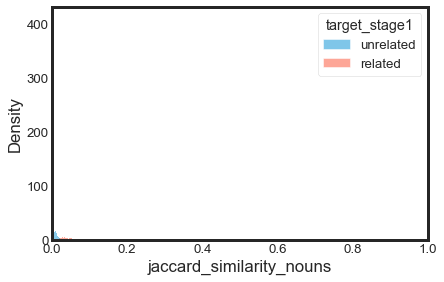

In [280]:
sns.histplot(df, x="jaccard_similarity_nouns", stat='density' , hue="target_stage1", common_norm=True)
plt.xlim(0, 1)
plt.show() 

Using scipy we can set the threshold line to maximize accuracy on the training set. Given statistical theory (STAT 341) the sampling distribution of the Jaccard score should resemble that of the true distribution of this attribute, therefore we should get good test set performance. We use the training set to determine the threshold. There might be room to refine this threshold placement by including the hold out set. We can do this later if we want but it shouldnt be neccessary. 

In [281]:
threshold = minimize_scalar(objective_a,bounds=[0,.2],method='Bounded')['x']
print(threshold)
print(accuracy_score(df.target_stage1, df.pred))

0.020006680717092478
0.9356228335570739


The bodies are typically long and with Jaccard we tend to get more error when the token size is large. We can optimize the token size of the examples as well specfically with respect to the body. Headlines are small enough. So using the optimized threshold we perform the token size optimization. 

In [282]:
token_sz = int(np.floor(minimize_scalar(objective_b,bounds=[5,600],method='Bounded', tol=.05)['x']))
df['jaccard_similarity_nouns'] = df.apply(lambda x: jaccard_similarity_token_opt(x.headline_ents, 
                                                                                 x.body_ents,
                                                                                 token_sz
                                                                                ), axis=1)
print(token_sz)
print(accuracy_score(df.target_stage1, df.pred))

KeyboardInterrupt: 

We now label on the basis on this threshold

In [283]:
df['pred']= 'unrelated'
df.loc[df.jaccard_similarity_nouns > threshold, 'pred'] = 'related'

In [284]:
df['jaccard_similarity_nouns'].describe()

count    49909.000000
mean         0.019152
std          0.040139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.023529
max          1.000000
Name: jaccard_similarity_nouns, dtype: float64

### Stage 1: Analysis

#### Functions:

In [285]:
from sklearn.metrics import classification_report

In [286]:
target_names = ['related', 'unrelated']
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
def classification_interpretation(y_pred, y_actual): 
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=target_names)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.set_palette(five_thirty_eight)
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style('ticks')
    sns.heatmap(cf_matrix, 
                xticklabels=target_names, 
                yticklabels=target_names, annot=labels, fmt='',cmap=five_thirty_eight[::-1],  linewidths=10)

#### Code:

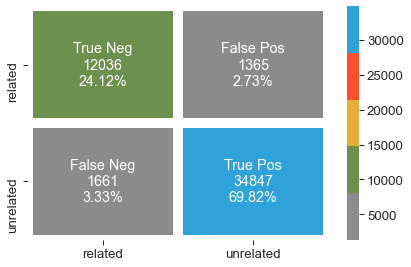

In [287]:
cf_matrix = confusion_matrix(df.target_stage1, df.pred)
classification_interpretation(df.pred, df.target_stage1)

In [288]:
display(pd.DataFrame(classification_report(df.target_stage1, df.pred, target_names=target_names,output_dict=True)))

,related,unrelated,accuracy,macro avg,weighted avg
precision,0.878733,0.962305,0.93937,0.920519,0.939865
recall,0.898142,0.954503,0.93937,0.926323,0.939370
f1-score,0.888331,0.958388,0.93937,0.923360,0.939577
support,13401.000000,36508.000000,0.93937,49909.000000,49909.000000


In [34]:
df.to_csv('stg1_results.csv', index=False)

##### Test set: 

Although this model was trained in the unsupervised way we can also see how it performs on the hold out set provided by the competition. 

In [35]:
global_pth = '/Users/nicholascalen/fnc-1/'
pth_to_bodies = global_pth + 'competition_test_bodies.csv'
pth_to_headlines = global_pth + 'competition_test_stances.csv'
test_headlines, test_bodies = load_and_join(pth_to_headlines, pth_to_bodies)

Pandas Apply:   0%|          | 0/904 [00:00<?, ?it/s]

In [36]:
test_bodies['body_ents'] = test_bodies['articleBody'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
test_headlines['headline_ents'] = test_headlines['Headline'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
test = test_headlines.join(test_bodies)

Pandas Apply:   0%|          | 0/904 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/904 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25413 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25413 [00:00<?, ?it/s]

In [37]:
test['headline_ents'] = test['headline_ents'].apply(lambda x: [y for y in x if y not in ['report','man', 'woman',
                                                                                         'appl','state','plan',
                                                                                         'famili', 'video',
                                                                                         'al','compani']])

In [50]:
test['jaccard_similarity_nouns'] = test.apply(lambda x: jaccard_similarity_token_opt(x.headline_ents, 
                                                                                 x.body_ents,
                                                                                 token_sz
                                                                                ), axis=1)

In [39]:
test['target_stage1'] = 'None'
test['labels'] = test.Stance
test.loc[test.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
test.loc[test.Stance != 'unrelated', 'target_stage1'] = 'related'
test.loc[test.Stance == 'unrelated', 'labels'] = None
#test.drop(['Stance'], inplace=True,axis=1)

In [51]:
test['pred'] ='unrelated'
test.loc[test.jaccard_similarity_nouns > threshold, 'pred'] = 'related'

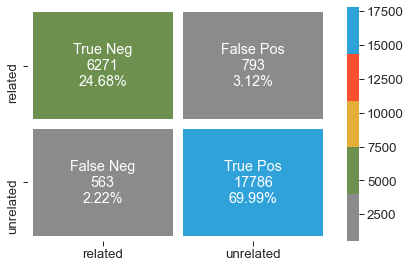

In [52]:
cf_matrix = confusion_matrix(test.target_stage1, test.pred)
classification_interpretation(test.pred, test.target_stage1)

In [53]:
display(pd.DataFrame(classification_report(test.target_stage1, test.pred, target_names=target_names,output_dict=True)))

,related,unrelated,accuracy,macro avg,weighted avg
precision,0.917618,0.957317,0.946641,0.937468,0.946282
recall,0.887741,0.969317,0.946641,0.928529,0.946641
f1-score,0.902432,0.963280,0.946641,0.932856,0.946366
support,7064.000000,18349.000000,0.946641,25413.000000,25413.000000


In [49]:
threshold = 0.02386085645671562; token_sz =68

In [44]:
test.to_csv('stg1_test_results_opt.csv', index=False)

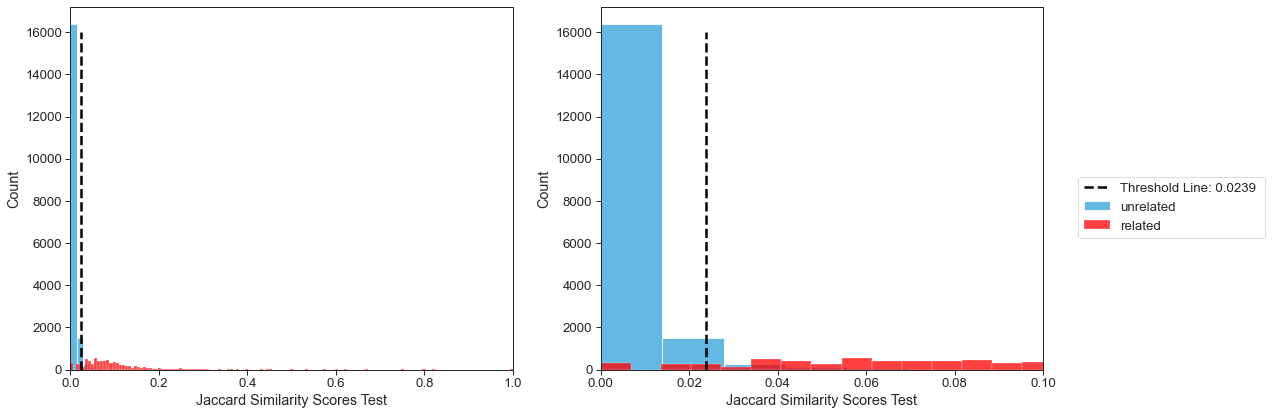

In [70]:
ur = test[['jaccard_similarity_nouns','target_stage1']].loc[test.target_stage1 == 'unrelated']
r = test[['jaccard_similarity_nouns','target_stage1']].loc[test.target_stage1 == 'related']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.histplot(ur.jaccard_similarity_nouns,ax=ax1,label='unrelated',common_norm=True)
sns.histplot(r.jaccard_similarity_nouns,color='red',ax=ax1,label='related',common_norm=True)
ax1.axis(xmin=0.,xmax=1)
sns.histplot(ur.jaccard_similarity_nouns,ax=ax2)
sns.histplot(r.jaccard_similarity_nouns,color='red',ax=ax2)
ax2.axis(xmin=0.,xmax=.1)
ax1.vlines(threshold, ymin =0,ymax= 16000, 
           label="Threshold Line: {:.4f} ".format(threshold), 
           color = "black", linestyles="dashed") 
ax2.vlines(threshold, ymin =0,ymax= 16000, color = "black", linestyles="dashed") 
ax1.set_xlabel('Jaccard Similarity Scores Test')
ax2.set_xlabel('Jaccard Similarity Scores Test')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('img/jaccard_test.png', dpi=200, bbox_inches ='tight',transparent=True)
plt.show()

#### Reset Threshold on Train + Test before competion

In [45]:
def objective_a(threshold): 
    df_all['pred'] ='unrelated'
    df_all.loc[df_all.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(df_all.target_stage1, df_all.pred)

def objective_b(token):
    df_all['pred'] ='unrelated'
    df_all['jaccard_similarity_nouns'] = df_all.apply(lambda x: jaccard_similarity_token_opt(x.headline_ents, 
                                                                                     x.body_ents, token), axis=1)
    df_all.loc[df_all.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(df_all.target_stage1, df_all.pred)

In [46]:
df_all = pd.concat([df, test],axis=0)

In [47]:
threshold = minimize_scalar(objective_a,bounds=[0,.2],method='Bounded')['x']
print(threshold)
print(accuracy_score(df_all.target_stage1, df_all.pred))
token_sz = int(np.floor(minimize_scalar(objective_b,bounds=[5,600],method='Bounded', tol=.05)['x']))
df_all['jaccard_similarity_nouns'] = df_all.apply(lambda x: jaccard_similarity_token_opt(x.headline_ents, 
                                                                                 x.body_ents,
                                                                                 token_sz
                                                                                ), axis=1)
print(token_sz)
print(accuracy_score(df_all.target_stage1, df_all.pred))
df_all['pred']= 'unrelated'
df_all.loc[df_all.jaccard_similarity_nouns > threshold, 'pred'] = 'related'

0.03411677348409402
0.953921763963605
52
0.954851564056585


              precision    recall  f1-score   support

     related       0.92      0.91      0.92     20457
   unrelated       0.97      0.97      0.97     54828

    accuracy                           0.95     75285
   macro avg       0.94      0.94      0.94     75285
weighted avg       0.95      0.95      0.95     75285



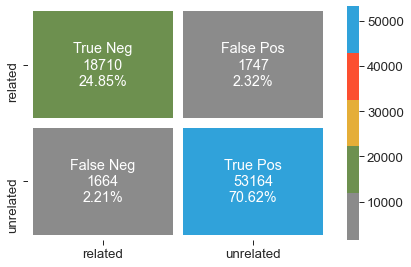

In [48]:
cf_matrix = confusion_matrix(df_all.target_stage1, df_all.pred)
classification_interpretation(df_all.pred, df_all.target_stage1)
print(classification_report(df_all.target_stage1, df_all.pred, target_names=target_names))

## Stage 2: Pipeline

For stage 2 the plan is to move away from the previous supervised model as nouns don't really given away any specfic pattern relating to the second target. I attempted a similar approach to try and group the posts by sentiment detection (positive, neutral, negative) but I had no luck. Supervised topic modeling is an interesting approach but likely out of the question as well since we need to look at a relation between a specfic headline and specfic post. So our only tool in the chest is really supervised learning. 

I'm going to use the fast.ai library to do this because it is generally the best. This part will require a gpu since we are dealing with text data. The approach will be to try a straight up text classifier and compare that to the ULMFit method. I'll experiment by adding additional text features to the model, specfically comparing results when adding the nouns from step one vs without. 

In [55]:
# sns.histplot(df, x="jaccard_similarity_nouns", hue="target_stage2", common_norm=True)
# plt.xlim(0, 1)
# plt.show() 

### Stage 1: Preprocess

Fastai will handle the technicalities here. 

### Stage 1: Model

In [ ]:
#!pip install datasets transformers

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
mapper = { 'agree': 0,  'disagree':1, 'discuss':2}

In [ ]:
df.labels =  df.labels.map(mapper)
df.labels.unique()
test.labels =  test.labels.map(mapper)

In [ ]:
cols = ['Headline', 'articleBody', 'labels']
test.loc[test.Stance == 'agree', 'labels'] = 0 #'agree'
test.loc[test.Stance == 'disagree', 'labels'] = 1 #'disagee'
test.loc[test.Stance == 'discuss', 'labels'] = 2 #'discuss'
test.loc[test.Stance == 'unrelated', 'labels'] = None
df.loc[df.Stance == 'agree', 'labels'] = 0 #'agree'
df.loc[df.Stance == 'disagree', 'labels'] = 1 #'disagree'
df.loc[df.Stance == 'discuss', 'labels'] = 2 #'discuss'
df.loc[df.Stance == 'unrelated', 'labels'] = None
train = Dataset.from_pandas(df.loc[~df.labels.isna()] [cols])
test_1 = Dataset.from_pandas( test.loc[~test.labels.isna()] [cols])
# 90% train, 10% test + validation
train_testvalid = train.train_test_split(0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test']
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_1,
    'valid':test_valid})

In [ ]:
train_test_valid_dataset

#### Text Classifier - General 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer
from datasets import load_metric
from transformers import TrainingArguments

def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def tokenize_function(example):
    return tokenizer(example["Headline"], example["articleBody"], padding = True, truncation=True)

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [ ]:
tokenized_train_test_valid_dataset = train_test_valid_dataset.map(tokenize_function, batched=True)
#tokenized_train_test_valid_dataset

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [ ]:
training_args = TrainingArguments("test-trainer",  
                                  evaluation_strategy="epoch", 
                                  per_device_train_batch_size=8, 
                                  per_device_eval_batch_size=8)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [ ]:
trainer.train()

#### Text Classifier - Data Augmentation

#### Best Option - Text Feature Addition 

Comments:

#### Best Option - Tuning with WANB

### Stage 2: Analysis

In [56]:
sums = pd.read_csv('/Users/nicholascalen/downloads/withSumTrain.csv')

In [78]:
sums['body_ents'] = sums['summarized_articles'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
sums['headline_ents'] = sums['Headline'].swifter.apply(clean_txt).swifter.apply(noun_tag) 
sums.shape

Pandas Apply:   0%|          | 0/49881 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49881 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49881 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49881 [00:00<?, ?it/s]

(49881, 7)

In [102]:
sums.to_csv('/Users/nicholascalen/downloads/withSumTrain.csv',index=False)

In [525]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.05)
                value = '{:.2f}'.format(p.get_height())# + "%"
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width()) #+ "%"
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [44]:
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')
ax = sns.barplot(x= 'unique_values',y='counts', 
                 data=test.Stance.value_counts().rename_axis('unique_values').to_frame('counts').reset_index())
show_values(ax)
plt.grid(False)
ax.set_facecolor('white')
sns.despine()

plt.xlabel('Stance')
plt.ylabel('Class Frequency')
plt.savefig('stance_dist.png', dpi=200, bbox_inches ='tight',transparent=True)
plt.show()

NameError: name 'test' is not defined

In [527]:
len(test)

25413

NameError: name 'show_values' is not defined

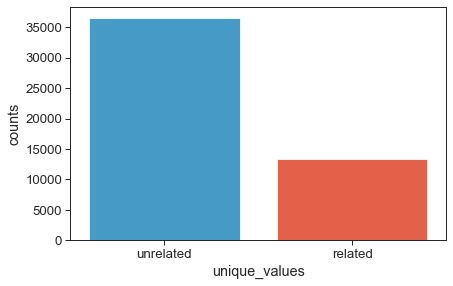

In [31]:
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')
ax = sns.barplot(x= 'unique_values', 
                 y='counts', 
                 data=df.target_stage1.value_counts().rename_axis('unique_values').to_frame('counts').reset_index())
show_values(ax)
plt.grid(False)
ax.set_facecolor('white')
sns.despine()

plt.xlabel('Stance')
plt.ylabel('Class Frequency')
plt.savefig('stance_dist_stg1.png',dpi=200, bbox_inches ='tight',transparent=True)
plt.show()

### Inference Pipeline 

In [360]:
# 1. Read Data
# 2. Clean
# 3. Tag 
# 4. Stage 1: 
    # threshold, tokensz, label 
# 5. Stage 2: 
    # Take related predictions then label w/ HF model 
# 6. Combine
# 7. Package and Submit OR Score 

In [421]:
df[['Headline','headline_ents']].iloc[0]

Headline         Soldier shot, Parliament locked down after gunfire erupts at war memorial
headline_ents                                   [soldier, parliament, gunfir, war, memori]
Name: 0, dtype: object

In [425]:
df[['articleBody','body_ents']].iloc[2000]

articleBody    Afghanistan veteran Sam Arnold uploaded this spine-chilling video of a US Marine getting a direct headshot from a Taliban sniper—only to be saved by his kevlar helmet. It's incredible to watch, especially the face of relief and disbelief of the impact victim. That was a really close call.\n\nAccording to Arnold, "the Marines were conducting a joint helicopter raid in the Now Zad district, Helmand Province in 2013. The shot occurs right at the :45 mark in the video."
body_ents                                                                                                                                                                                                                                                   [afghanistan, veteran, sam, arnold, spine, video, marin, headshot, taliban, sniper, kevlar, helmet, face, relief, disbelief, impact, victim, arnold, marin, helicopt, raid, zad, district, helmand, provinc, 2013, shot, 45, mark, video]
Name: 115, dtype: object

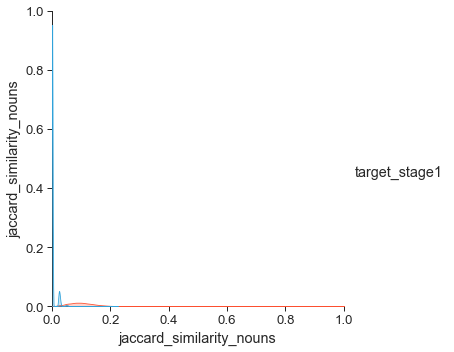

In [426]:
sns.pairplot(df[['jaccard_similarity_nouns','target_stage1']], hue='target_stage1',size=(5))
plt.xlim(0, 1)
plt.show()

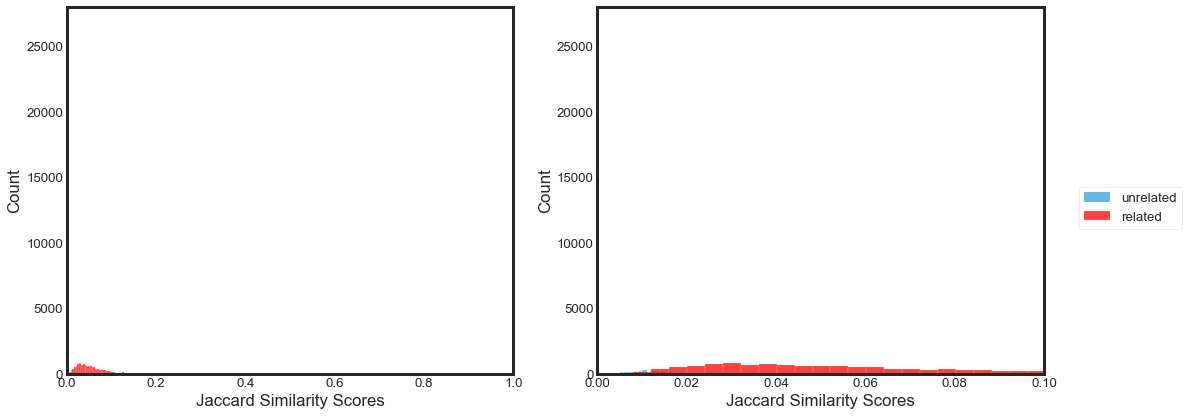

In [249]:
ur = df[['jaccard_similarity_nouns','target_stage1']].loc[df.target_stage1 == 'unrelated']
r = df[['jaccard_similarity_nouns','target_stage1']].loc[df.target_stage1 == 'related']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.histplot(ur.jaccard_similarity_nouns,ax=ax1,label='unrelated',common_norm=True)
sns.histplot(r.jaccard_similarity_nouns,color='red',ax=ax1,label='related',common_norm=True)
ax1.axis(xmin=0.,xmax=1)
sns.histplot(ur.jaccard_similarity_nouns,ax=ax2)
sns.histplot(r.jaccard_similarity_nouns,color='red',ax=ax2)
ax2.axis(xmin=0.,xmax=.1)
ax1.set_xlabel('Jaccard Similarity Scores')
ax2.set_xlabel('Jaccard Similarity Scores')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('img/jaccard.png', dpi=200, bbox_inches ='tight',transparent=True)
plt.show()

In [503]:
ax1.axis?

In [500]:
sns.histplot?

In [465]:
sns.distplot?

In [456]:
sns.distplot?

In [451]:
sns.distplot?

In [437]:
df.jaccard_similarity_nouns.mean()

0.03218642615982221

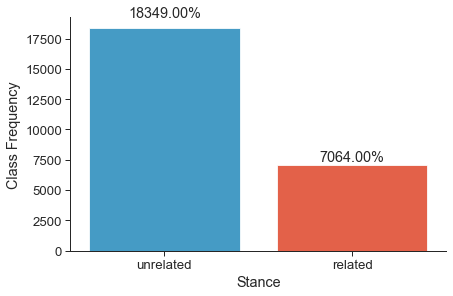

In [524]:
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')
ax = sns.barplot(x= 'unique_values', 
                 y='counts', 
                 data=test.target_stage1.value_counts().rename_axis('unique_values').to_frame('counts').reset_index())
show_values(ax)
plt.grid(False)
ax.set_facecolor('white')
sns.despine()

plt.xlabel('Stance')
plt.ylabel('Class Frequency')
plt.savefig('stance_dist_stg1.png',dpi=200, bbox_inches ='tight',transparent=True)
plt.show()